# **Personalisation and Machine Learning Mini-Project**
## Content-based filtering of Bookstore Data

In this notebook, I will be using content-base filtering on a Goodreads dataset to create recommendations based on genre and book synopsis for veteran bookworms and casual book enjoyers. My dataset is taken from https://www.kaggle.com/datasets/ishikajohari/best-books-10k-multi-genre-data.

The code for this notebook is partially adapted from Wk2.1 notebook.

### Load and Prepare Dataset

In [32]:
## IMPORT CELL ##
import pandas as pd 
import numpy as np 
import json
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import spatial
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


In [2]:
# Load in dataset #
books = pd.read_csv('data/goodreads_data.csv')
books.head()

,Unnamed: 0,Book,Author,Description,Genres,Avg_Rating,Num_Ratings,URL
0,0,To Kill a Mockingbird,Harper Lee,The unforgettable novel of a childhood in a sl...,"['Classics', 'Fiction', 'Historical Fiction', ...",4.27,"5,691,311",https://www.goodreads.com/book/show/2657.To_Ki...
1,1,Harry Potter and the Philosopher’s Stone (Harr...,J.K. Rowling,Harry Potter thinks he is an ordinary boy - un...,"['Fantasy', 'Fiction', 'Young Adult', 'Magic',...",4.47,"9,278,135",https://www.goodreads.com/book/show/72193.Harr...
2,2,Pride and Prejudice,Jane Austen,"Since its immediate success in 1813, Pride and...","['Classics', 'Fiction', 'Romance', 'Historical...",4.28,"3,944,155",https://www.goodreads.com/book/show/1885.Pride...
3,3,The Diary of a Young Girl,Anne Frank,Discovered in the attic in which she spent the...,"['Classics', 'Nonfiction', 'History', 'Biograp...",4.18,"3,488,438",https://www.goodreads.com/book/show/48855.The_...
4,4,Animal Farm,George Orwell,Librarian's note: There is an Alternate Cover ...,"['Classics', 'Fiction', 'Dystopia', 'Fantasy',...",3.98,"3,575,172",https://www.goodreads.com/book/show/170448.Ani...


As the genres are already in a usable state, we can just clean up the dataset by removing unnecessary columns and any empty rows.

In [3]:
# Check for null rows
books.isnull().any()  #Some books have no descriptions in the dataset
# Remove empty values so that results won't be affected
books.dropna(inplace=True)
print('After removing empty descriptions, there are',
      len(books), 'to work with.')
books = books.drop('Unnamed: 0', axis=1)
books.head()

After removing empty descriptions, there are 9923 to work with.


,Book,Author,Description,Genres,Avg_Rating,Num_Ratings,URL
0,To Kill a Mockingbird,Harper Lee,The unforgettable novel of a childhood in a sl...,"['Classics', 'Fiction', 'Historical Fiction', ...",4.27,"5,691,311",https://www.goodreads.com/book/show/2657.To_Ki...
1,Harry Potter and the Philosopher’s Stone (Harr...,J.K. Rowling,Harry Potter thinks he is an ordinary boy - un...,"['Fantasy', 'Fiction', 'Young Adult', 'Magic',...",4.47,"9,278,135",https://www.goodreads.com/book/show/72193.Harr...
2,Pride and Prejudice,Jane Austen,"Since its immediate success in 1813, Pride and...","['Classics', 'Fiction', 'Romance', 'Historical...",4.28,"3,944,155",https://www.goodreads.com/book/show/1885.Pride...
3,The Diary of a Young Girl,Anne Frank,Discovered in the attic in which she spent the...,"['Classics', 'Nonfiction', 'History', 'Biograp...",4.18,"3,488,438",https://www.goodreads.com/book/show/48855.The_...
4,Animal Farm,George Orwell,Librarian's note: There is an Alternate Cover ...,"['Classics', 'Fiction', 'Dystopia', 'Fantasy',...",3.98,"3,575,172",https://www.goodreads.com/book/show/170448.Ani...


In [4]:
books['Genres'] = books['Genres'].str.strip('[]').str.replace(' ','').str.replace("'",'')
books['Genres'] = books['Genres'].str.split(',')

### *Content-Based Filtering Recommender: By Genre*

The first recommendation system will be based on the book genres in the dataset.

#### Looking at Dataset Statistics

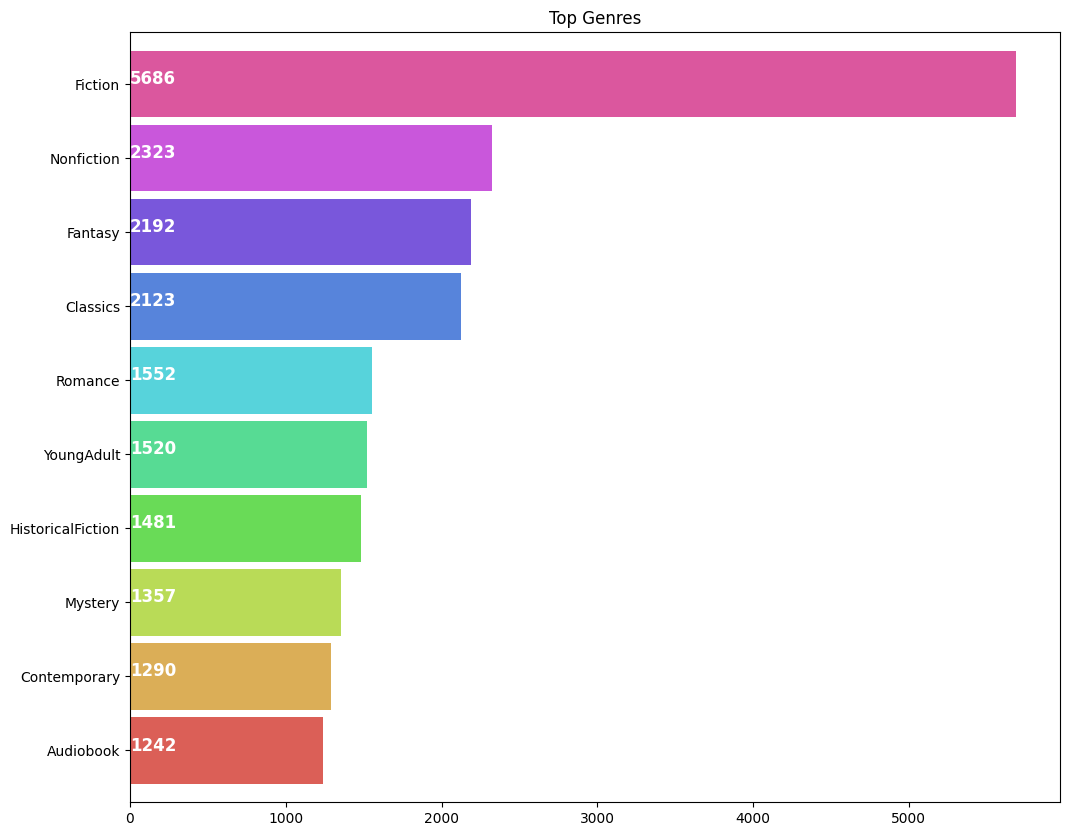

In [5]:
# We can create a bar chart to see how many books fall under each genre.

plt.subplots(figsize=(12,10))
list1 = []
for i in books['Genres']:
    list1.extend(i)
ax = pd.Series(list1).value_counts()[:10].sort_values(ascending=True).plot.barh(width=0.9,color=sns.color_palette('hls',10))
for i, v in enumerate(pd.Series(list1).value_counts()[:10].sort_values(ascending=True).values): 
    ax.text(.8, i, v,fontsize=12,color='white',weight='bold')
plt.title('Top Genres')
plt.show()

In this dataset, 'fiction', 'nonfiction' and 'audiobook' are included as genres. Although it can be argued that fiction and non-fiction can be argued to be broad genres, audiobook is just refering to the story's format.

In [6]:
for i,j in zip(books['Genres'],books.index):
    list2=[]
    list2=i
    list2.sort()
    books.loc[j,'Genres']=str(list2)
books['Genres'] = books['Genres'].str.strip('[]').str.replace(' ','').str.replace("'",'')
books['Genres'] = books['Genres'].str.split(',')

In [7]:
# Find unique genres in the dataset

genre_list = []
for index, row in books.iterrows():
    genres = row["Genres"]
    
    for genre in genres:
        if genre not in genre_list:
            genre_list.append(genre)
genre_list[:10] #now we have a list with unique genres

['Classics',
 'Fiction',
 'Historical',
 'HistoricalFiction',
 'Literature',
 'School',
 'YoungAdult',
 'Childrens',
 'Fantasy',
 'Magic']

In [8]:
# Convert the genres into binaries

def binary(GenreList):
    binaryList = []
    
    for genre in genre_list:
        if genre in GenreList:
            binaryList.append(1)
        else:
            binaryList.append(0)
    
    return binaryList

### One Hot Encoding and Similarity

Now that we know the unique genres in the dataset, we can generate a one-hot encoding. This is so that the genres can be represented as a feature vector for the recommender.

In [9]:
books['genres_bin'] = books['Genres'].apply(lambda x: binary(x))
books['genres_bin'].head()

0    [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...
1    [1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, ...
2    [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, ...
3    [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...
4    [1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...
Name: genres_bin, dtype: object

With the one-hot encodings, we can now find the the cosine simialrity of any two books.

In [10]:
def Similarity(bookId1, bookId2):
    a = books.iloc[bookId1]
    b = books.iloc[bookId2]
    
    genresA = a['genres_bin']
    genresB = b['genres_bin']
    
    genreDistance = spatial.distance.cosine(genresA, genresB)
    return genreDistance 

# Test
print(Similarity(50,100))
print(books.iloc[50])
print(books.iloc[100])  

0.8571428571428572
Book                                               The Outsiders
Author                                               S.E. Hinton
Description    The Outsiders is about two weeks in the life o...
Genres         [Classics, ComingOfAge, Fiction, ReadForSchool...
Avg_Rating                                                  4.12
Num_Ratings                                            1,220,608
URL            https://www.goodreads.com/book/show/231804.The...
genres_bin     [1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: 50, dtype: object
Book                      The Da Vinci Code (Robert Langdon, #2)
Author                                                 Dan Brown
Description    ISBN 9780307277671 moved to this edition.While...
Genres         [Adventure, Fiction, HistoricalFiction, Myster...
Avg_Rating                                                   3.9
Num_Ratings                                            2,249,143
URL            https://www.goodreads.com/book/s

Create a new dataframe for the genre recommender, including a column for the custom book IDs. Then use K-NN to produce 10 recommendations for each query.

In [11]:
books_id = list(range(0,books.shape[0]))
books['id'] = books_id
books_by_genre = books[['Book','Genres','Avg_Rating','genres_bin','id']]
books_by_genre = books_by_genre.rename(columns={'Book': 'Title'})
books_by_genre.head()

,Title,Genres,Avg_Rating,genres_bin,id
0,To Kill a Mockingbird,"[Classics, Fiction, Historical, HistoricalFict...",4.27,"[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
1,Harry Potter and the Philosopher’s Stone (Harr...,"[Childrens, Classics, Fantasy, Fiction, Magic,...",4.47,"[1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, ...",1
2,Pride and Prejudice,"[Audiobook, Classics, Fiction, Historical, His...",4.28,"[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, ...",2
3,The Diary of a Young Girl,"[Biography, Classics, Historical, History, Hol...",4.18,"[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...",3
4,Animal Farm,"[Classics, Dystopia, Fantasy, Fiction, Literat...",3.98,"[1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",4


In [35]:
# Use K-NN to find the 10 recommendations

import operator

def recommend_by_genre(name):
    #name = input('Enter a book title: ')
    new_book = books_by_genre[books_by_genre['Title'].str.contains(name)].iloc[0].to_frame().T
    print('You enjoyed reading: ',new_book.Title.values[0])
    def getNeighbors(baseBook, K):
        distances = []
    
        for index, book in books_by_genre.iterrows():
            if book['id'] != baseBook['id'].values[0]:
                dist = Similarity(baseBook['id'].values[0], book['id'])
                distances.append((book['id'], dist))
    
        distances.sort(key=operator.itemgetter(1))
        neighbors = []
    
        for x in range(K):
            neighbors.append(distances[x])
        return neighbors

    K = 10
    avgRating = 0
    neighbors = getNeighbors(new_book, K)
    
    print('\nWhy not pick one of these for your next read: \n')
    for neighbor in neighbors:
        avgRating = avgRating+books_by_genre.iloc[neighbor[0]][2]  
        print( books_by_genre.iloc[neighbor[0]][0]+" | Genres: "+str(books_by_genre.iloc[neighbor[0]][1]).strip('[]').replace(' ','')+" | Rating: "+str(books_by_genre.iloc[neighbor[0]][2]))
    
    print('\n')
    avgRating = avgRating/K
   

With the genre recommender coded, let's test it with a few sample readers of varying interests and tastes.

In [36]:
# Example reader 1: 
# This reader is interested in gothic romantic novels

recommend_by_genre('Wuthering Heights')

You enjoyed reading:  Wuthering Heights

Why not pick one of these for your next read: 

Northanger Abbey | Genres: '19thCentury','Classics','Fiction','Gothic','HistoricalFiction','Literature','Romance' | Rating: 3.84
Jane Eyre | Genres: 'Classics','Fiction','Gothic','Historical','HistoricalFiction','Literature','Romance' | Rating: 4.14
Tess of the D'Urbervilles | Genres: '19thCentury','Classics','Fiction','HistoricalFiction','Literature','Romance','Victorian' | Rating: 3.82
Mansfield Park | Genres: '19thCentury','Classics','Fiction','Historical','HistoricalFiction','Literature','Romance' | Rating: 3.86
Far From the Madding Crowd | Genres: '19thCentury','Classics','Fiction','HistoricalFiction','Literature','Romance','Victorian' | Rating: 3.96
Vanity Fair | Genres: '19thCentury','BritishLiterature','Classics','Fiction','HistoricalFiction','Literature','Romance' | Rating: 3.8
The Tenant of Wildfell Hall | Genres: '19thCentury','Classics','Fiction','Gothic','HistoricalFiction','Romance','

In [23]:
# Example reader 2: 
# This reader is a big fantasy fan

recommend_by_genre('The Lord of the Rings')

You enjoyed reading:  The Lord of the Rings

Why not pick one of these for your next read: 

The Fellowship of the Ring (The Lord of the Rings, #1) | Genres: 'Adventure','Classics','EpicFantasy','Fantasy','Fiction','HighFantasy','ScienceFictionFantasy' | Rating: 4.38
The Return of the King (The Lord of the Rings, #3) | Genres: 'Adventure','Classics','EpicFantasy','Fantasy','Fiction','HighFantasy','ScienceFictionFantasy' | Rating: 4.56
The Two Towers (The Lord of the Rings, #2) | Genres: 'Adventure','Classics','EpicFantasy','Fantasy','Fiction','HighFantasy','ScienceFictionFantasy' | Rating: 4.47
J.R.R. Tolkien 4-Book Boxed Set: The Hobbit and The Lord of the Rings | Genres: 'Adventure','Classics','EpicFantasy','Fantasy','Fiction','HighFantasy','ScienceFictionFantasy' | Rating: 4.61
The Children of Húrin | Genres: 'Adventure','Classics','EpicFantasy','Fantasy','Fiction','HighFantasy','ScienceFictionFantasy' | Rating: 4.01
The Hobbit (The Lord of the Rings, #0) | Genres: 'Adventure','Clas

The recommender can also distinguish books of the same genre but with different tones.

In [25]:
# Example reader 3:
# This reader loves science fiction stories that are quite dark

recommend_by_genre("Dune") # Regex will not work with this recommender

You enjoyed reading:  Dune (Dune, #1)

Why not pick one of these for your next read: 

Ringworld (Ringworld, #1) | Genres: 'Audiobook','Classics','Fantasy','Fiction','ScienceFiction','ScienceFictionFantasy','SpaceOpera' | Rating: 3.95
Dune Messiah (Dune, #2) | Genres: 'Audiobook','Classics','Fantasy','Fiction','ScienceFiction','ScienceFictionFantasy','SpaceOpera' | Rating: 3.89
Heretics of Dune (Dune, #5) | Genres: 'Audiobook','Classics','Fantasy','Fiction','ScienceFiction','ScienceFictionFantasy','SpaceOpera' | Rating: 3.87
God Emperor of Dune (Dune, #4) | Genres: 'Audiobook','Classics','Fantasy','Fiction','ScienceFiction','ScienceFictionFantasy','SpaceOpera' | Rating: 3.87
The Foundation Trilogy (Foundation, #1-3) | Genres: 'Classics','Fantasy','Fiction','Literature','ScienceFiction','ScienceFictionFantasy','SpaceOpera' | Rating: 4.41
The Martian Chronicles | Genres: 'Audiobook','Classics','Fantasy','Fiction','ScienceFiction','ScienceFictionFantasy','ShortStories' | Rating: 4.15
Foun

In [26]:
# Example reader 4:
# This reader loves science fiction stories but also funny stories

recommend_by_genre("The Hitchhiker's Guide to the Galaxy")

You enjoyed reading:  The Hitchhiker's Guide to the Galaxy (The Hitchhiker's Guide to the Galaxy, #1)

Why not pick one of these for your next read: 

The Ultimate Hitchhiker's Guide to the Galaxy (Hitchhiker's Guide to the Galaxy, #1-5) | Genres: 'Classics','Comedy','Fantasy','Fiction','Humor','ScienceFiction','ScienceFictionFantasy' | Rating: 4.38
Life, the Universe and Everything (The Hitchhiker's Guide to the Galaxy, #3) | Genres: 'Classics','Comedy','Fantasy','Fiction','Humor','ScienceFiction','ScienceFictionFantasy' | Rating: 4.18
The Hitchhiker's Guide to the Galaxy: A Trilogy in Four Parts | Genres: 'Classics','Comedy','Fantasy','Fiction','Humor','ScienceFiction','ScienceFictionFantasy' | Rating: 4.5
Mostly Harmless (Hitchhiker's Guide to the Galaxy, #5) | Genres: 'Classics','Comedy','Fantasy','Fiction','Humor','ScienceFiction','ScienceFictionFantasy' | Rating: 3.97
The Restaurant at the End of the Universe (Hitchhiker's Guide to the Galaxy, #2) | Genres: 'Classics','Comedy','F

This recommender can also work for those with limited interest or on behalf of someone else.

In [27]:
# Example reader 5:
# The reader only bought the Bible

recommend_by_genre("The Holy Bible: King James Version")

You enjoyed reading:  The Holy Bible: King James Version

Why not pick one of these for your next read: 

The Holy Bible | Genres: 'Christian','Christianity','Classics','History','Nonfiction','Philosophy','Religion' | Rating: 4.43
Mere Christianity | Genres: 'Christian','Christianity','Classics','Nonfiction','Philosophy','Religion','Theology' | Rating: 4.35
City of God | Genres: 'Christianity','Classics','History','Nonfiction','Philosophy','Religion','Theology' | Rating: 3.92
Orthodoxy | Genres: 'Christian','Christianity','Classics','Nonfiction','Philosophy','Religion','Theology' | Rating: 4.17
Martin Luther's Ninety-Five Theses | Genres: 'Christian','Classics','History','Nonfiction','Philosophy','Religion','Theology' | Rating: 3.88
The Everlasting Man | Genres: 'Christian','Christianity','Classics','Nonfiction','Philosophy','Religion','Theology' | Rating: 4.14
The New Testament | Genres: 'Christian','Christianity','Classics','Nonfiction','Philosophy','Religion','Spirituality' | Rating

In [28]:
# Example reader 5:
# This person's not much of a reader but bought books for her little nephew
recommend_by_genre("Matilda")

You enjoyed reading:  Matilda

Why not pick one of these for your next read: 

Charlie and the Chocolate Factory (Charlie Bucket, #1) | Genres: 'Childrens','Classics','Fantasy','Fiction','Humor','MiddleGrade','YoungAdult' | Rating: 4.15
Pippi Longstocking (Pippi Långstrump, #1) | Genres: 'Childrens','Classics','Fantasy','Fiction','Humor','MiddleGrade','YoungAdult' | Rating: 4.15
The BFG | Genres: 'Childrens','Classics','Fantasy','Fiction','Humor','MiddleGrade','YoungAdult' | Rating: 4.22
The Twits | Genres: 'Childrens','Classics','Fantasy','Fiction','Humor','MiddleGrade','YoungAdult' | Rating: 3.97
George's Marvellous Medicine | Genres: 'Childrens','Classics','Fantasy','Fiction','Humor','MiddleGrade','YoungAdult' | Rating: 4.03
Esio Trot | Genres: 'Childrens','Classics','Fantasy','Fiction','Humor','MiddleGrade','YoungAdult' | Rating: 3.74
Harry Potter and the Philosopher’s Stone (Harry Potter, #1) | Genres: 'Childrens','Classics','Fantasy','Fiction','Magic','MiddleGrade','YoungAdult' |

From our test readers' results, the genre recommender seems to work very well, although I did notice that some recommendations were very biased towards a  series or author depending on the input book. Although, books in the same series or books written by the same author would be very similar (so I would expect the same sort of results if we put a Hunger Games book or Harry Potter book in the system).

We can build another recommendation system that involves more information, such as book synopsis.

### *Content-Based Filtering Recommender: By Synopsis*

As I used a seperate dataframe for the Genre Recommender, there would be no need to reload the dataset.

As we are now dealing with full blocks of text and not categorial data, we will need to use natural language processing like a TF-IDF vectoriser to deal with the book synopses.

In [29]:
books.head()

,Book,Author,Description,Genres,Avg_Rating,Num_Ratings,URL,genres_bin,id
0,To Kill a Mockingbird,Harper Lee,The unforgettable novel of a childhood in a sl...,"[Classics, Fiction, Historical, HistoricalFict...",4.27,"5,691,311",https://www.goodreads.com/book/show/2657.To_Ki...,"[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
1,Harry Potter and the Philosopher’s Stone (Harr...,J.K. Rowling,Harry Potter thinks he is an ordinary boy - un...,"[Childrens, Classics, Fantasy, Fiction, Magic,...",4.47,"9,278,135",https://www.goodreads.com/book/show/72193.Harr...,"[1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, ...",1
2,Pride and Prejudice,Jane Austen,"Since its immediate success in 1813, Pride and...","[Audiobook, Classics, Fiction, Historical, His...",4.28,"3,944,155",https://www.goodreads.com/book/show/1885.Pride...,"[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, ...",2
3,The Diary of a Young Girl,Anne Frank,Discovered in the attic in which she spent the...,"[Biography, Classics, Historical, History, Hol...",4.18,"3,488,438",https://www.goodreads.com/book/show/48855.The_...,"[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...",3
4,Animal Farm,George Orwell,Librarian's note: There is an Alternate Cover ...,"[Classics, Dystopia, Fantasy, Fiction, Literat...",3.98,"3,575,172",https://www.goodreads.com/book/show/170448.Ani...,"[1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",4


In [31]:
# Define a TF-IDF Vectorizer Object 
# We will also remove all english stop words
tfidf = TfidfVectorizer(stop_words='english')

# Construct the required TF-IDF matrix 
# by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(books['Description'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

(9923, 70064)

While the Genre Recommender was built using K-Nearest Neighbour, we will use cosine similarity as the backbone of our Plot Recommender.

In [33]:
# Compute the cosine similarity matrix
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [34]:
#Construct a reverse map of indices and book titles
indices = pd.Series(books.index, index=books['Book']).drop_duplicates()

Now we can build the Plot Recommender. 

In [39]:
# Function that takes in book title as input and outputs most similar books
def recommend_by_plot(title, cosine_sim=cosine_sim):

    print('You enjoyed reading: ',title)

    # Get the index of the book that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all books with the input book
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the books by the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar books
    sim_scores = sim_scores[1:11]

    # Get the book indices
    book_indices = [i[0] for i in sim_scores]

    print('\nWhy not pick one of these for your next read: \n')

    # Return the top 10 most similar movies
    return books['Book'].iloc[book_indices]

As before, we will use test readers to see if the recommender works.

In [40]:
# Test Reader 1

recommend_by_plot('The Princess Bride')

You enjoyed reading:  The Princess Bride

Why not pick one of these for your next read: 



2009    A Dad After God's Own Heart: Becoming the Fath...
696                                    Rich Dad, Poor Dad
3090    As You Wish: Inconceivable Tales from the Maki...
5856                                       Living My Life
2899                            The Present (VanWest, #2)
7268                        Bad : Six Sexy Gents Unmasked
8493                                   The Lion in Winter
135     The Return of the King (The Lord of the Rings,...
5034                      Danny the Champion of the World
8309    The School for Good and Evil (The School for G...
Name: Book, dtype: object

In [41]:
# Test Reader 2

recommend_by_plot('The Perks of Being a Wallflower')

You enjoyed reading:  The Perks of Being a Wallflower

Why not pick one of these for your next read: 



3992                                         Jasper Jones
1969                      Anansi Boys (American Gods, #2)
5093                                    As the Crow Flies
9567    Tales from a Not-So-Fabulous Life (Dork Diarie...
3368                        A Dirty Job (Grim Reaper, #1)
7061                 Stalk Me (The Keatyn Chronicles, #1)
6249                                            Solitaire
66                                   Flowers for Algernon
4476    Charlie and the Great Glass Elevator (Charlie ...
4810                                           Dyed Souls
Name: Book, dtype: object

In [42]:
#Test Reader 3

recommend_by_plot("Alice's Adventures in Wonderland / Through the Looking-Glass")

You enjoyed reading:  Alice's Adventures in Wonderland / Through the Looking-Glass

Why not pick one of these for your next read: 



7499                                     Living Dead Girl
8096                  The Hazel Wood (The Hazel Wood, #1)
8789                           The Other Side of the Fire
132                                   Alice in Wonderland
3025                                    The First Mistake
3115                                    What Alice Forgot
8070                          Splintered (Splintered, #1)
8864                                        Without Alice
1797    Alice's Adventures in Wonderland (Alice's Adve...
415                                           Still Alice
Name: Book, dtype: object

In [44]:
# Test reader 4

recommend_by_plot('The Great Gatsby')

You enjoyed reading:  The Great Gatsby

Why not pick one of these for your next read: 



6160                          The Beginning of Everything
3380                                This Side of Paradise
9497                                  Powers of Influence
2172                                    The Speed of Life
2204    The Great Book of Amber (The Chronicles of Amb...
4151                             The Beautiful and Damned
5260                  The Curious Case of Benjamin Button
1739                  The Dark Tower (The Dark Tower, #7)
1045                   Kerri's War (The King Trilogy, #3)
6764                                      Gone (Wake, #3)
Name: Book, dtype: object

In [47]:
# Test reader 5

recommend_by_plot('American Psycho')

You enjoyed reading:  American Psycho

Why not pick one of these for your next read: 



5868                                        Murphy's Path
7335    Makers and Takers: The Rise of Finance and the...
750                                           Bleak House
4279                                Dogshit Saved My Life
8596                        Sacred (Kenzie & Gennaro, #3)
7287                   The American Dream & The Zoo Story
8152    Psycho-Cybernetics, A New Way to Get More Livi...
2770                                            Black Boy
1311                 Slave to the Dream: Everyone’s Dream
1972                     Flash Boys: A Wall Street Revolt
Name: Book, dtype: object

From the results, the Plot Recommender seems to give us more diverse recommendations - very good for those wanting to read something new but may not be the best for those who like particular books.

### *Content-Based Filtering Recommender: By Rating*

The two recommendation systemsboth rely on the user putting in a book that they like/ have read but what if they want to find books from authors that are similar to their favourite author? We can build a system that brings up authors (along with a book they have written).

To do this successfully, it will be best to build the recommendation system that works by author __and__ genre (some authors are known for writing bookd of certain authors; some authors write in multiple genres).

For ease of the code operating, the system will still require a book title as the input.

In [48]:
# We will adapt the code for the Genre Recommender
# to give us recommendations of new authors (and their books)

# Add book authors to book_by_genre dataset
books_authors = books_by_genre
books_authors['author'] = books['Author']
books_authors.head()

,Title,Genres,Avg_Rating,genres_bin,id,author
0,To Kill a Mockingbird,"[Classics, Fiction, Historical, HistoricalFict...",4.27,"[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,Harper Lee
1,Harry Potter and the Philosopher’s Stone (Harr...,"[Childrens, Classics, Fantasy, Fiction, Magic,...",4.47,"[1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, ...",1,J.K. Rowling
2,Pride and Prejudice,"[Audiobook, Classics, Fiction, Historical, His...",4.28,"[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, ...",2,Jane Austen
3,The Diary of a Young Girl,"[Biography, Classics, Historical, History, Hol...",4.18,"[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...",3,Anne Frank
4,Animal Farm,"[Classics, Dystopia, Fantasy, Fiction, Literat...",3.98,"[1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",4,George Orwell


In [85]:
# Adapt Genre recommender code for Author Recommender

def recommend_by_author(name):
    new_book = books_authors[books_authors['Title'].str.contains(name)].iloc[0].to_frame().T
    search_term = new_book.Title.values[0]
    fav_author = books_authors[books_authors['Title'] == search_term]['author'].values[0]

    print('You seem to like books written by: ',fav_author)

    # We want books made by different authors so we make a seperate dataframe
    books_authors_search = books_authors[books_authors.author != fav_author]

    # But the row for the base book will still need to be in the dataframe

    # Get index of base book row
    idx = books_authors.index[books_authors['Title'] == search_term]
    #Append row to new df
    books_authors_search = pd.concat([books_authors_search, books_authors.iloc[idx]], axis=0, ignore_index=True)
    
    #books_authors_search = books_authors_search.append(books_authors.iloc[idx])
    #Program stated that above methoded may not work with future versions of Pandas

    def getNeighbors(baseBook, K):
        distances = []
    
        for index, book in books_authors_search.iterrows():
            if book['id'] != baseBook['id'].values[0]:
                dist = Similarity(baseBook['id'].values[0], book['id'])
                distances.append((book['id'], dist))
    
        distances.sort(key=operator.itemgetter(1))
        neighbors = []
    
        for x in range(K):
            neighbors.append(distances[x])
        return neighbors

    K = 10
    avgRating = 0
    neighbors = getNeighbors(new_book, K)
    
    print('\nYou may also like books by these authors: \n')
    for neighbor in neighbors:
        avgRating = avgRating+books_authors.iloc[neighbor[0]][2]  
        print(books_authors.iloc[neighbor[0]][5]+" | Book: "+str(books_authors.iloc[neighbor[0]][0]+" | Rating: "+str(books_by_genre.iloc[neighbor[0]][2])))
    
    print('\n')
    #avgRating = avgRating/K

With the recommender built, we can now test it!

In [86]:
# Test reader 1
# This reader is a big Potterhead but has already read the entire series

recommend_by_author('Harry Potter and the Prisoner of Azkaban')

You seem to like books written by:  J.K. Rowling

You may also like books by these authors: 

Kennilworthy Whisp | Book: Quidditch Through the Ages | Rating: 3.81
Newt Scamander | Book: Fantastic Beasts and Where to Find Them | Rating: 3.96
Kelly Barnhill | Book: The Girl Who Drank the Moon | Rating: 4.12
Cornelia Funke | Book: Inkheart (Inkworld, #1) | Rating: 3.91
Diana Wynne Jones | Book: Howl’s Moving Castle (Howl’s Moving Castle, #1) | Rating: 4.29
Neil Gaiman | Book: Coraline | Rating: 4.1
Brandon Mull | Book: Fablehaven (Fablehaven, #1) | Rating: 4.12
P.L. Travers | Book: Mary Poppins (Mary Poppins, #1) | Rating: 4.02
Patricia C. Wrede | Book: Dealing with Dragons (Enchanted Forest Chronicles, #1) | Rating: 4.15
Shannon Messenger | Book: Keeper of the Lost Cities (Keeper of the Lost Cities, #1) | Rating: 4.43




In [87]:
# Test reader 2
# This reader wants to read books with a similar aesthetic

recommend_by_author('The Picture of Dorian Gray')

You seem to like books written by:  Oscar Wilde

You may also like books by these authors: 

Mervyn Peake | Book: The Gormenghast Novels (Gormenghast, #1-3) | Rating: 4.01
Mervyn Peake | Book: Gormenghast (Gormenghast, #2) | Rating: 4.06
Mervyn Peake | Book: Titus Groan (Gormenghast, #1) | Rating: 3.92
Matthew Gregory Lewis | Book: The Monk | Rating: 3.82
Aldous Huxley | Book: Brave New World / Brave New World Revisited | Rating: 4.16
Gabriel García Márquez | Book: One Hundred Years of Solitude | Rating: 4.11
Mary Wollstonecraft Shelley | Book: Frankenstein: The 1818 Text | Rating: 3.85
Anthony Burgess | Book: A Clockwork Orange | Rating: 4.0
Bram Stoker | Book: Dracula | Rating: 4.01
Anne Rice | Book: Interview with the Vampire (The Vampire Chronicles, #1) | Rating: 4.01




In [88]:
# Test reader 3
# This reader enjoys Shakespeare but wants to read something new

recommend_by_author('Macbeth')

You seem to like books written by:  William Shakespeare

You may also like books by these authors: 

Arthur  Miller | Book: The Crucible: A Play in Four Acts | Rating: 3.6
Oscar Wilde | Book: The Importance of Being Earnest | Rating: 4.18
Arthur  Miller | Book: Death of a Salesman | Rating: 3.56
Sophocles | Book: Antigone (The Theban Plays, #3) | Rating: 3.66
Sophocles | Book: Oedipus Rex  (The Theban Plays, #1) | Rating: 3.72
Tennessee Williams | Book: The Glass Menagerie | Rating: 3.73
Tennessee Williams | Book: A Streetcar Named Desire | Rating: 3.98
George Bernard Shaw | Book: Pygmalion | Rating: 3.89
Robert Bolt | Book: A Man for All Seasons: A Play in Two Acts | Rating: 3.88
Sophocles | Book: Antigone; Oedipus the King; Electra | Rating: 3.94




In [89]:
# Test reader 4
# This reader loves sad romance stories

recommend_by_author('The Fault in Our Stars')

You seem to like books written by:  John Green

You may also like books by these authors: 

Rob Thomas | Book: Rats Saw God | Rating: 3.79
Laurie Halse Anderson | Book: Speak | Rating: 4.04
Gayle Forman | Book: If I Stay (If I Stay, #1) | Rating: 3.92
Rainbow Rowell | Book: Eleanor & Park | Rating: 3.96
Ann Brashares | Book: The Sisterhood of the Traveling Pants (Sisterhood, #1) | Rating: 3.83
Sarah Dessen | Book: Just Listen | Rating: 4.05
Jenny Downham | Book: Before I Die | Rating: 3.81
Laurie Halse Anderson | Book: Speak | Rating: 4.04
Sarah Dessen | Book: Along for the Ride | Rating: 4.04
Justina Chen | Book: North of Beautiful | Rating: 3.92




In [90]:
# Test reader 5
# This reader likes dystopian stories

recommend_by_author("The Handmaid's Tale")

You seem to like books written by:  Margaret Atwood

You may also like books by these authors: 

Roald Dahl | Book: Some Time Never: A Fable for Supermen | Rating: 3.23
Janet E. Morris | Book: Wind from the Abyss (Silistra, #3) | Rating: 3.99
Lois Lowry | Book: The Giver (The Giver, #1) | Rating: 4.12
Aldous Huxley | Book: Brave New World / Brave New World Revisited | Rating: 4.16
George Orwell | Book: Animal Farm / 1984 | Rating: 4.3
H.G. Wells | Book: The Time Machine | Rating: 3.9
Philip K. Dick | Book: Do Androids Dream of Electric Sheep? | Rating: 4.09
Ursula K. Le Guin | Book: The Left Hand of Darkness | Rating: 4.09
William Gibson | Book: Neuromancer (Sprawl, #1) | Rating: 3.9
Ursula K. Le Guin | Book: The Dispossessed: An Ambiguous Utopia | Rating: 4.24




### Concluding Remarks

In this notebook, I have made three content-based recommendation systems based on book genre, plot synopsis and author. While they were all successfully able to work, I have some remarks on the results (more detailed discussions will be in the corresponding report in the repository).

From the results, it seems that going by genre produced the most sensible results, even the author recommender was adapted from the genre recommender code (and worked the same). Genre results were very similar but were saturated by books of the same author or series. The plot synopsis recommender was more suitable for giving diverse results, however, the results may not really be related.